In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
import tensorflow as tf
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from keras.models import Model

2022-11-11 00:36:38.594151: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-11 00:36:38.594174: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
rating = pd.read_csv('./datasets/tourism_rating.csv')
user = pd.read_csv('./datasets/user.csv')

In [3]:
rating.describe()

,User_Id,Place_Id,Place_Ratings
count,10000.000000,10000.000000,10000.000000
mean,151.292700,219.416400,3.066500
std,86.137374,126.228335,1.379952
min,1.000000,1.000000,1.000000
25%,77.000000,108.750000,2.000000
50%,151.000000,220.000000,3.000000
75%,226.000000,329.000000,4.000000
max,300.000000,437.000000,5.000000


In [4]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   User_Id        10000 non-null  int64
 1   Place_Id       10000 non-null  int64
 2   Place_Ratings  10000 non-null  int64
dtypes: int64(3)
memory usage: 234.5 KB


In [5]:
n_tourisms = rating['Place_Id'].nunique()
n_users = rating['User_Id'].nunique()

In [6]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(rating, test_size=0.2, random_state=42)

In [7]:
# creating book embedding path
tourism_input = Input(shape=[1], name="Tourism-Input")
tourism_embedding = Embedding(n_tourisms+1, 5, name="Tourism-Embedding")(tourism_input)
tourism_vec = Flatten(name="Flatten-Tourism")(tourism_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# concatenate features
conc = Concatenate()([tourism_vec, user_vec])

# add fully-connected-layers
fc1 = Dense(256, activation='relu')(conc)
fc2 = Dense(128, activation='relu')(fc1)
fc3 = Dense(128, activation='relu')(fc2)
out = Dense(1)(fc3)



2022-11-11 00:36:40.786897: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-11-11 00:36:40.786922: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Nitro-AN515-44): /proc/driver/nvidia/version does not exist
2022-11-11 00:36:40.787172: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
# Create model and compile it
model = Model([user_input, tourism_input], out)
model.compile('adam', 'mean_squared_error')

# see the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Tourism-Input (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 User-Input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 Tourism-Embedding (Embedding)  (None, 1, 5)         2190        ['Tourism-Input[0][0]']          
                                                                                                  
 User-Embedding (Embedding)     (None, 1, 5)         1505        ['User-Input[0][0]']             
                                                                                              

In [9]:
history = model.fit([train.User_Id, train.Place_Id], train.Place_Ratings, epochs=100, verbose=1)


Epoch 1/100
250/250 [==============================] - 1s 2ms/step - loss: 2.5002
Epoch 2/100
250/250 [==============================] - 0s 2ms/step - loss: 1.9098
Epoch 3/100
250/250 [==============================] - 0s 2ms/step - loss: 1.8344
Epoch 4/100
250/250 [==============================] - 0s 2ms/step - loss: 1.7929
Epoch 5/100
250/250 [==============================] - 0s 2ms/step - loss: 1.7698
Epoch 6/100
250/250 [==============================] - 0s 2ms/step - loss: 1.7286
Epoch 7/100
250/250 [==============================] - 0s 2ms/step - loss: 1.6624
Epoch 8/100
250/250 [==============================] - 0s 2ms/step - loss: 1.6112
Epoch 9/100
250/250 [==============================] - 0s 2ms/step - loss: 1.5575
Epoch 10/100
250/250 [==============================] - 0s 2ms/step - loss: 1.4912
Epoch 11/100
250/250 [==============================] - 0s 2ms/step - loss: 1.4145
Epoch 12/100
250/250 [==============================] - 0s 2ms/step - loss: 1.3633
Epoch 13/100


Text(0, 0.5, 'Training Error')

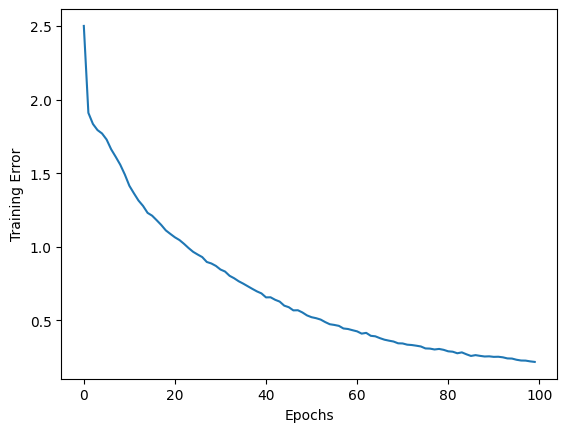

In [10]:
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Training Error")

In [11]:
model.evaluate([test.User_Id, test.Place_Id], test.Place_Ratings)


63/63 [==============================] - 0s 1ms/step - loss: 3.7217


3.7217493057250977

In [12]:
id_place = range(1,20)

# Creating dataset for making recommendations for the first user
tourism_data = np.array(list(set(rating.Place_Id)))
tourism_data[:10]

id_user = 3
user = np.array([id_user for i in range(len(tourism_data))])
user[:10]

predictions = model.predict([user, tourism_data])

predictions = np.array([a[0] for a in predictions])

recommended_tourism_ids = (-predictions).argsort()[:10]

print(recommended_tourism_ids)

# print predicted scores
predictions[recommended_tourism_ids]

14/14 [==============================] - 0s 1ms/step
[436 139  31  95 425 237 374  86 258 160]


array([5.636406 , 5.6007094, 5.5648746, 5.5642314, 5.5535917, 5.440391 ,
       5.437306 , 5.4009166, 5.367679 , 5.342446 ], dtype=float32)